In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec
from models import CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier, TClassifier
from training_function import training
from config_dataset import custom_dataset
from accuracy import classifier_accuracy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sequence_length = 20
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [4]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('text_corpus/divina_commedia.txt',
                                                                                                                                                        'text_corpus/uno_nessuno_e_i_malavoglia.txt',
                                                                                                                                                        'text_corpus/lo_cunto_de_li_cunti.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  633
len val loader:  80
total number of training samples:  20246
total number of validation samples:  2529
vocab size:  26606


In [5]:
style0_test.shape

torch.Size([1017, 20])

# CNN Classifier

In [6]:
cnn_classifier = CNNClassifier(embedding_matrix, 3, 3, [3,3,3])

In [7]:
classifier_params = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8139


 12%|█▎        | 1/8 [00:03<00:22,  3.19s/it]

====> Epoch: 1 Average train loss: 0.0198, Average val loss: 0.0182


 25%|██▌       | 2/8 [00:06<00:19,  3.21s/it]

====> Epoch: 2 Average train loss: 0.0178, Average val loss: 0.0180


 38%|███▊      | 3/8 [00:09<00:15,  3.20s/it]

====> Epoch: 3 Average train loss: 0.0176, Average val loss: 0.0179


 50%|█████     | 4/8 [00:12<00:12,  3.02s/it]

====> Epoch: 4 Average train loss: 0.0175, Average val loss: 0.0179


 62%|██████▎   | 5/8 [00:15<00:08,  2.99s/it]

====> Epoch: 5 Average train loss: 0.0174, Average val loss: 0.0179


 75%|███████▌  | 6/8 [00:18<00:05,  2.93s/it]

====> Epoch: 6 Average train loss: 0.0174, Average val loss: 0.0179


 88%|████████▊ | 7/8 [00:20<00:02,  2.91s/it]

====> Epoch: 7 Average train loss: 0.0173, Average val loss: 0.0178


100%|██████████| 8/8 [00:23<00:00,  2.97s/it]

====> Epoch: 8 Average train loss: 0.0173, Average val loss: 0.0178


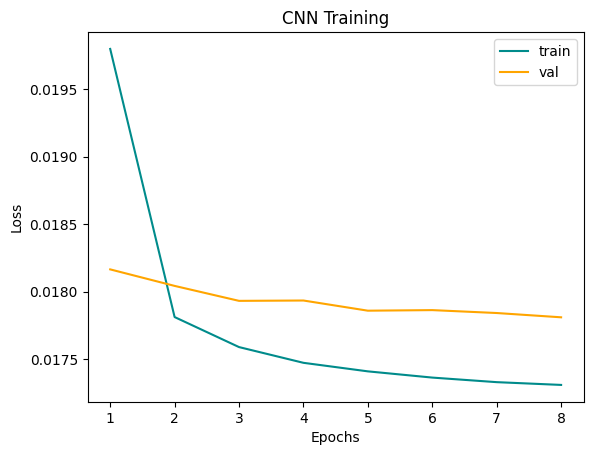

In [8]:
train_losses = training(cnn_classifier, train_loader, val_loader, 8, 4e-4, 'CNN Training')

### Examples with CNN 

In [143]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = cnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  57.61168599128723 %
Input sequence: 
 io non tanto averraggio tormiento de scrastareme da sto nigro cuorpo quanto de scantoniareme da ssa bella perzona cossì dicendo


# CNN Classifier Accuracy

In [10]:
classifier_accuracy(cnn_classifier, style0_test, style1_test, style2_test, 'CNN')

Accuracy predicting Dante:  0.9852507374631269
Accuracy predicting Italian:  0.992133726647001
Accuracy predicting Neapolitan:  0.998
Overall  CNN  Accuracy:  0.9917948213700427


# RNN Classifier

In [11]:
rnn_classifier = RNNClassifier(embedding_matrix, hidden_dim, 1)

In [12]:
classifier_params = sum(p.numel() for p in rnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3107


 10%|█         | 1/10 [00:01<00:16,  1.81s/it]

====> Epoch: 1 Average train loss: 0.0290, Average val loss: 0.0254


 20%|██        | 2/10 [00:03<00:14,  1.87s/it]

====> Epoch: 2 Average train loss: 0.0218, Average val loss: 0.0207


 30%|███       | 3/10 [00:05<00:12,  1.79s/it]

====> Epoch: 3 Average train loss: 0.0171, Average val loss: 0.0159


 40%|████      | 4/10 [00:07<00:10,  1.72s/it]

====> Epoch: 4 Average train loss: 0.0140, Average val loss: 0.0134


 50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

====> Epoch: 5 Average train loss: 0.0114, Average val loss: 0.0107


 60%|██████    | 6/10 [00:10<00:06,  1.64s/it]

====> Epoch: 6 Average train loss: 0.0087, Average val loss: 0.0086


 70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

====> Epoch: 7 Average train loss: 0.0065, Average val loss: 0.0064


 80%|████████  | 8/10 [00:13<00:03,  1.65s/it]

====> Epoch: 8 Average train loss: 0.0047, Average val loss: 0.0049


 90%|█████████ | 9/10 [00:15<00:01,  1.63s/it]

====> Epoch: 9 Average train loss: 0.0036, Average val loss: 0.0042


100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

====> Epoch: 10 Average train loss: 0.0030, Average val loss: 0.0039


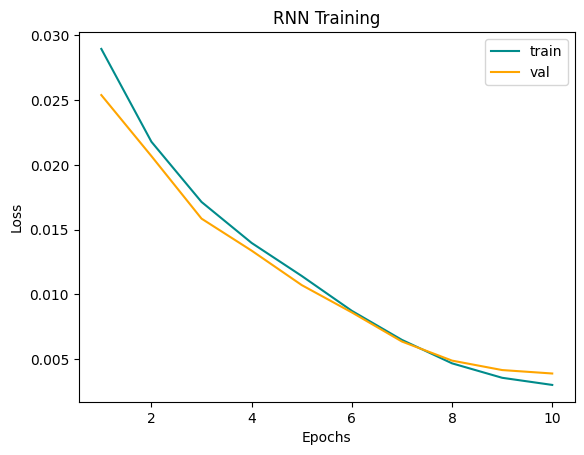

In [13]:
train_losses = training(rnn_classifier, train_loader, val_loader, 10, 4e-4, 'RNN Training')

In [153]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = rnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  96.19741439819336 %
Input sequence: 
 ve la dicere comme sta restava de mala voglia a sto pajese ma pocca lo cielo me l ha mannata


# RNN Classifier Accuracy

In [15]:
classifier_accuracy(rnn_classifier, style0_test, style1_test, style2_test, 'RNN')

Accuracy predicting Dante:  0.9823008849557522
Accuracy predicting Italian:  0.976401179941003
Accuracy predicting Neapolitan:  0.978
Overall  RNN  Accuracy:  0.9789006882989183


# GRU Classifier

In [16]:
gru_classifier = GRUClassifier(embedding_matrix, hidden_dim, 1)

In [17]:
classifier_params = sum(p.numel() for p in gru_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8067


 10%|█         | 1/10 [00:03<00:31,  3.45s/it]

====> Epoch: 1 Average train loss: 0.0257, Average val loss: 0.0170


 20%|██        | 2/10 [00:06<00:27,  3.38s/it]

====> Epoch: 2 Average train loss: 0.0110, Average val loss: 0.0073


 30%|███       | 3/10 [00:09<00:22,  3.22s/it]

====> Epoch: 3 Average train loss: 0.0052, Average val loss: 0.0043


 40%|████      | 4/10 [00:12<00:18,  3.14s/it]

====> Epoch: 4 Average train loss: 0.0031, Average val loss: 0.0032


 50%|█████     | 5/10 [00:15<00:15,  3.10s/it]

====> Epoch: 5 Average train loss: 0.0021, Average val loss: 0.0026


 60%|██████    | 6/10 [00:19<00:12,  3.21s/it]

====> Epoch: 6 Average train loss: 0.0015, Average val loss: 0.0021


 70%|███████   | 7/10 [00:22<00:09,  3.21s/it]

====> Epoch: 7 Average train loss: 0.0011, Average val loss: 0.0020


 80%|████████  | 8/10 [00:26<00:06,  3.34s/it]

====> Epoch: 8 Average train loss: 0.0008, Average val loss: 0.0020


 90%|█████████ | 9/10 [00:29<00:03,  3.45s/it]

====> Epoch: 9 Average train loss: 0.0006, Average val loss: 0.0027


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]

====> Epoch: 10 Average train loss: 0.0005, Average val loss: 0.0019


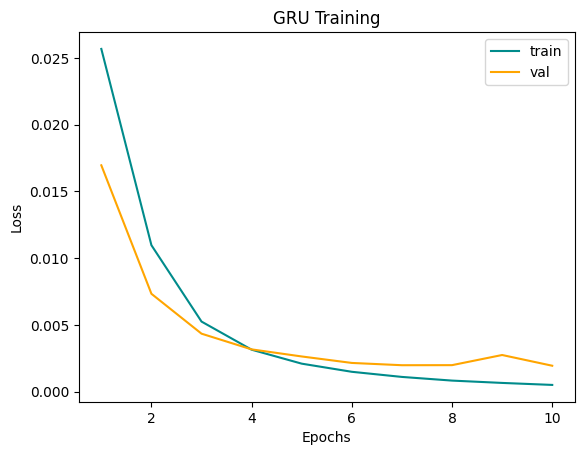

In [18]:
train_losses = training(gru_classifier, train_loader, val_loader, 10, 4e-4, 'GRU Training')

In [154]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = gru_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.8595654964447 %
Input sequence: 
 parente già era l caponsacco nel mercato disceso giù da fiesole e già era buon cittadino giuda e infangato io


# GRU Classifier Accuracy

In [20]:
classifier_accuracy(gru_classifier, style0_test, style1_test, style2_test, 'GRU')

Accuracy predicting Dante:  0.9754178957718781
Accuracy predicting Italian:  0.992133726647001
Accuracy predicting Neapolitan:  0.996
Overall  GRU  Accuracy:  0.987850540806293


# LSTM Classifier

In [21]:
lstm_classifier = LSTMClassifier(embedding_matrix, hidden_dim, 1)

In [22]:
classifier_params = sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  10547


 10%|█         | 1/10 [00:01<00:15,  1.70s/it]

====> Epoch: 1 Average train loss: 0.0256, Average val loss: 0.0109


 20%|██        | 2/10 [00:03<00:14,  1.81s/it]

====> Epoch: 2 Average train loss: 0.0058, Average val loss: 0.0033


 30%|███       | 3/10 [00:05<00:12,  1.72s/it]

====> Epoch: 3 Average train loss: 0.0024, Average val loss: 0.0022


 40%|████      | 4/10 [00:06<00:09,  1.64s/it]

====> Epoch: 4 Average train loss: 0.0015, Average val loss: 0.0018


 50%|█████     | 5/10 [00:08<00:07,  1.58s/it]

====> Epoch: 5 Average train loss: 0.0011, Average val loss: 0.0017


 60%|██████    | 6/10 [00:09<00:06,  1.58s/it]

====> Epoch: 6 Average train loss: 0.0008, Average val loss: 0.0017


 70%|███████   | 7/10 [00:11<00:04,  1.57s/it]

====> Epoch: 7 Average train loss: 0.0006, Average val loss: 0.0018


 80%|████████  | 8/10 [00:12<00:03,  1.55s/it]

====> Epoch: 8 Average train loss: 0.0005, Average val loss: 0.0016


 90%|█████████ | 9/10 [00:14<00:01,  1.53s/it]

====> Epoch: 9 Average train loss: 0.0004, Average val loss: 0.0015


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]

====> Epoch: 10 Average train loss: 0.0003, Average val loss: 0.0015


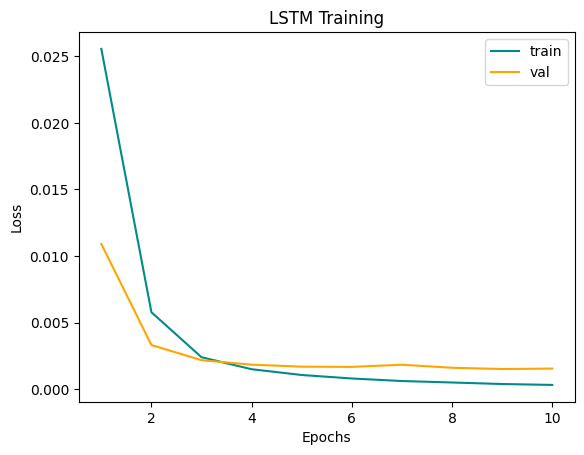

In [23]:
train_losses = training(lstm_classifier, train_loader, val_loader, 10, 4e-4, 'LSTM Training')

In [159]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = lstm_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.85785484313965 %
Input sequence: 
 menti non capere in triangol due ottusi così vedi le cose contingenti anzi che sieno in sè mirando il punto


# LSTM Accuracy

In [25]:
classifier_accuracy(lstm_classifier, style0_test, style1_test, style2_test, 'LSTM')

Accuracy predicting Dante:  0.983284169124877
Accuracy predicting Italian:  0.9950835791543756
Accuracy predicting Neapolitan:  0.996
Overall  LSTM  Accuracy:  0.9914559160930843


# Transformer Classifier

In [28]:
t_classifier = TClassifier(embedding_matrix)

In [29]:
classifier_params = sum(p.numel() for p in t_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3188599


 20%|██        | 1/5 [00:30<02:00, 30.01s/it]

====> Epoch: 1 Average train loss: 0.0011, Average val loss: 0.0007


 40%|████      | 2/5 [01:00<01:31, 30.45s/it]

====> Epoch: 2 Average train loss: 0.0003, Average val loss: 0.0006


 60%|██████    | 3/5 [01:31<01:00, 30.41s/it]

====> Epoch: 3 Average train loss: 0.0002, Average val loss: 0.0006


 80%|████████  | 4/5 [02:01<00:30, 30.47s/it]

====> Epoch: 4 Average train loss: 0.0002, Average val loss: 0.0010


100%|██████████| 5/5 [02:32<00:00, 30.54s/it]

====> Epoch: 5 Average train loss: 0.0002, Average val loss: 0.0011


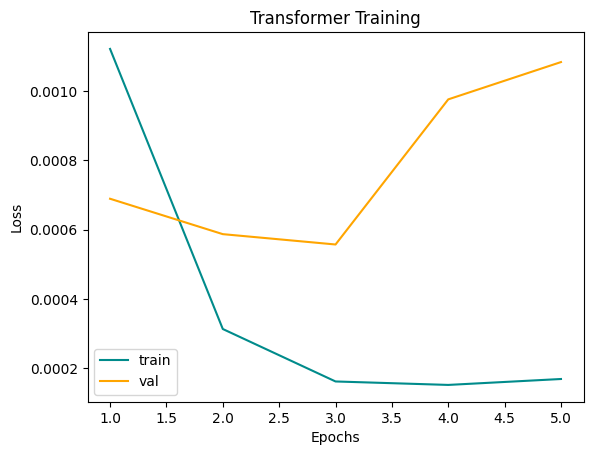

In [30]:
train_losses = training(t_classifier, train_loader, val_loader, 5, 4e-4, 'Transformer Training')

In [164]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = t_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.9979019165039 %
Input sequence: 
 t eran possenti il nome del bel fior ch io sempre invoco e mane e sera tutto mi ristrinse l


# Transformer Classifier Accuracy

In [32]:
classifier_accuracy(t_classifier, style0_test, style1_test, style2_test, 'Transformer')

Accuracy predicting Dante:  0.9852507374631269
Accuracy predicting Italian:  0.9941002949852508
Accuracy predicting Neapolitan:  1.0
Overall  Transformer  Accuracy:  0.9931170108161259
